<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/image/image_classification_NSWF_500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# blocks output in Colab üíÑ
%%capture

! pip install datasets transformers
! pip install accelerate wandb bitsandbytes -U -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_data_train = "/content/drive/MyDrive/data/train/"
path_data_validation = "/content/drive/MyDrive/data/validation"
path_data_test = "/content/drive/MyDrive/data/test"

In [4]:
label_dic={"drawings":0, "hentai": 1,"neutral":2, "porn": 3,"sexy": 4}

In [5]:
from datasets import ClassLabel, Dataset, Features, Image, Value, Sequence, DatasetDict
from PIL import Image as PImage, ImageOps
import numpy as np

In [6]:
 Clabels= ClassLabel(num_classes=5, names=["drawings", "hentai", "neutral", "porn", "sexy"])

In [7]:
import os
import glob

list_images=[]
list_path=[]
list_labels=[]
list_cats=[]

from fnmatch import fnmatch
pattern = "*.jpg"

# Train Dataset
for path, subdirs, files in os.walk(path_data_train):
    for name in files:
      if fnmatch(name, pattern):
            abs_path = (os.path.join(path, name))
            # abs_path
            category=abs_path.split("/")[-2]
            # name
            image = PImage.open(abs_path)
            image = ImageOps.fit(image,(400,400))
            list_images.append(image)
            list_path.append(abs_path)
            list_labels.append(label_dic.get(category))
            list_cats.append(category)



dtrain= { "image": list_images, "image_file_path": list_path, "labels":list_labels}
ds_train = Dataset.from_dict(mapping=dtrain, features=Features({"labels": Value(dtype='int8'), 'image_file_path': Value(dtype='string'), 'image': Image()}))
ds_train = ds_train.cast_column("labels", Clabels)
ds_train

Casting the dataset:   0%|          | 0/2500 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'image_file_path', 'labels'],
    num_rows: 2500
})

In [8]:
# Validation Dataset
list_images=[]
list_path=[]
list_labels=[]
list_cats=[]


# validation Dataset
for path, subdirs, files in os.walk(path_data_validation):
    for name in files:
      if fnmatch(name, pattern):
            abs_path = (os.path.join(path, name))
            # abs_path
            category=abs_path.split("/")[-2]
            # name
            image = PImage.open(abs_path)
            image = ImageOps.fit(image,(400,400))
            list_images.append(image)
            list_path.append(abs_path)
            list_labels.append(label_dic.get(category))
            list_cats.append(category)



dvalidation= { "image": list_images, "image_file_path": list_path, "labels":list_labels}
ds_validation = Dataset.from_dict(mapping=dvalidation, features=Features({"labels": Value(dtype='int8'), 'image_file_path': Value(dtype='string'), 'image': Image()}))
ds_validation = ds_validation.cast_column("labels", Clabels)
ds_validation

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'image_file_path', 'labels'],
    num_rows: 1000
})

In [9]:
# test Dataset
list_images=[]
list_path=[]
list_labels=[]
list_cats=[]


# test Dataset
for path, subdirs, files in os.walk(path_data_test):
    for name in files:
      if fnmatch(name, pattern):
            abs_path = (os.path.join(path, name))
            # abs_path
            category=abs_path.split("/")[-2]
            # name
            image = PImage.open(abs_path)
            image = ImageOps.fit(image,(400,400))
            list_images.append(image)
            list_path.append(abs_path)
            list_labels.append(label_dic.get(category))
            list_cats.append(category)



dtest= { "image": list_images, "image_file_path": list_path, "labels":list_labels}
ds_test = Dataset.from_dict(mapping=dtest, features=Features({"labels": Value(dtype='int8'), 'image_file_path': Value(dtype='string'), 'image': Image()}))
ds_test = ds_test.cast_column("labels", Clabels)
ds_test

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'image_file_path', 'labels'],
    num_rows: 1000
})

In [10]:
ds = DatasetDict({"train": ds_train, "validation": ds_validation, "test": ds_test})

In [11]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'image_file_path', 'labels'],
        num_rows: 2500
    })
    validation: Dataset({
        features: ['image', 'image_file_path', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'image_file_path', 'labels'],
        num_rows: 1000
    })
})

In [12]:
ds['train'].features

{'image': Image(decode=True, id=None),
 'image_file_path': Value(dtype='string', id=None),
 'labels': ClassLabel(names=['drawings', 'hentai', 'neutral', 'porn', 'sexy'], id=None)}

## Load a dataset

Let's start by loading a small image classification dataset and taking a look at its structure.

We'll use the [`beans`](https://huggingface.co/datasets/beans) dataset, which is a collection of pictures of healthy and unhealthy bean leaves. üçÉ



Let's take a look at the 400th example from the `'train'` split from the beans dataset. You'll notice each example from the dataset has 3 features:

1. `image`: A PIL Image
1. `image_file_path`: The `str` path to the image file that was loaded as `image`
1. `labels`: A [`datasets.ClassLabel`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel) feature, which we'll see as an integer representation of the label for a given example. (Later we'll see how to get the string class names, don't worry)

In [13]:
ex = ds['train'][400]
ex

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=400x400>,
 'image_file_path': '/content/drive/MyDrive/data/train/drawings/4f833df873650ea9cd5c4a032bc2e246a42ac61dc52c76b7cbaae29a38e6d815.jpg',
 'labels': 0}

Let's take a look at the image üëÄ

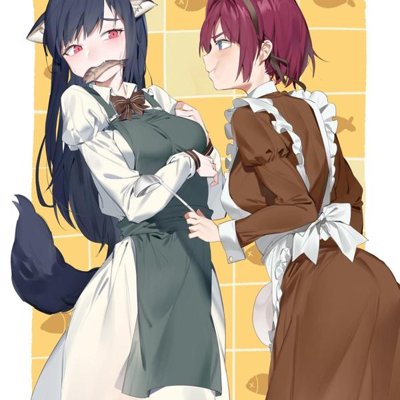

In [14]:
image = ex['image']
image

Thats definitely a leaf! But what kind? üòÖ

Since the `'labels'` feature of this dataset is a `datasets.features.ClassLabel`, we can use it to lookup the corresponding name for this example's label ID.

First, lets access the feature definition for the `'labels'`.

In [15]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['drawings', 'hentai', 'neutral', 'porn', 'sexy'], id=None)

Now, lets print out the class label for our example. We'll do that by using the [`int2str`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) function of `ClassLabel`, which, as the name implies, lets us pass the int representation of the class to look up the string label.

In [16]:
labels.int2str(ex['labels'])

'drawings'

Turns out the leaf shown above is infected with Bean Rust, a serious disease in bean plants. üò¢

Let's write a function that'll display a grid of examples from each class so we can get a better idea of what we're working with.

From what I'm seeing,
- Angular Leaf Spot: Has irregular brown patches
- Bean Rust:  Has circular brown spots surrounded with a white-ish yellow ring
- Healthy: ...looks healthy. ü§∑‚Äç‚ôÇÔ∏è

## Loading ViT Feature Extractor

Now that we know what our images look like and have a better understanding of the problem we're trying to solve, let's see how we can prepare these images for our model.

When ViT models are trained, specific transformations are applied to images being fed into them. Use the wrong transformations on your image and the model won't be able to understand what it's seeing! üñº ‚û°Ô∏è üî¢

To make sure we apply the correct transformations, we will use a [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) model, so lets load its feature extractor from the ü§ó Hub.

In [17]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


If we print a feature extractor, we can see its configuration.

In [18]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensors='pt'` argument, we'll get back `torch` tensors instead.


In [19]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ..., -0.0353, -0.0196, -0.0275],
          [ 1.0000,  1.0000,  1.0000,  ..., -0.0275, -0.0196, -0.0275],
          [ 1.0000,  1.0000,  1.0000,  ..., -0.0275, -0.0196, -0.0275]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ..., -0.3804, -0.3647, -0.3725],
          [ 1.0000,  1.0000,  1.0000,  ..., -0.3725, -0.3647, -0.3725],
          [ 1.0000,  1.0000,  1.0000,  ..., -0.3725, -0.3647, -0.3725]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1

## Processing the Dataset

Now that we know how to read in images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [20]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [21]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]]), 'labels': 0}

While we could call `ds.map` and apply this to every example at once, this can be very slow, especially if you use a larger dataset. Instead, we'll apply a ***transform*** to the dataset. Transforms are only applied to examples as you index them.

First, though, we'll need to update our last function to accept a batch of data, as that's what `ds.with_transform` expects.

In [22]:


def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

We can directly apply this to our dataset using `ds.with_transform(transform)`.

In [23]:
prepared_ds = ds.with_transform(transform)

Now, whenever we get an example from the dataset, our transform will be
applied in real time (on both samples and slices, as shown below)

In [24]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1

# Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We will make use of ü§ó's Trainer, but that'll require us to do a few things first:

- Define a collate function.

- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images.

### Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ‚ú®

In [25]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [26]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-26-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library ü§ó Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the ü§ó hub widget if we choose to `push_to_hub`.

In [27]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We're almost ready to train! The last thing we'll do before that is set up the training configuration by defining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [28]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

Now, all instances can be passed to Trainer and we are ready to start training!



In [29]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [30]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 721719797GF
  train_loss               =      0.2287
  train_runtime            =  0:04:18.75
  train_samples_per_second =      38.646
  train_steps_per_second   =       2.427


In [31]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.901
  eval_loss               =      0.333
  eval_runtime            = 0:00:14.51
  eval_samples_per_second =     68.916
  eval_steps_per_second   =      8.614


In [32]:
PROJECT = "NSFW-fine_tune"
MODEL_NAME = 'google/vit-base-patch16-224-in21k'
DATASET = "NSFF"

In [33]:
import wandb
wandb.init(project=PROJECT, # the project I am working on
           tags=[MODEL_NAME, DATASET],
           notes ="Classification Fine Tune NSFW dataset with google/vit-base-patch16-224-in21k") # the Hyperparameters I want to keep track of

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [35]:
dataset_path = "/content/drive/MyDrive/data/nsfw_HF"

In [37]:
ds_train.save_to_disk(os.path.join(dataset_path,"train.hf"))
ds_validation.save_to_disk(os.path.join(dataset_path,"validation.hf"))
ds_test.save_to_disk(os.path.join(dataset_path,"test.hf"))

Saving the dataset (0/2 shards):   0%|          | 0/2500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [38]:
trainer.state.best_model_checkpoint

'./vit-base-beans-demo-v5/checkpoint-400'

In [39]:
trainer.state.best_model_checkpoint
!mkdir nsfw_model
custom_path = "./nsfw_model/"
trainer.save_model(output_dir=custom_path)

In [40]:
with wandb.init(project=PROJECT, job_type="models"):
  artifact = wandb.Artifact("nsfw_2500", type="model")
  artifact.add_dir(custom_path)
  wandb.save(custom_path)
  wandb.log_artifact(artifact)

wandb: Currently logged in as: olonok (olonok69). Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (./nsfw_model)... Done. 1.1s


In [41]:
wandb.finish()